In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import Model, Input
from keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose


def SelectTargetEmotion(idx):
    print(">> Target Emotion:", end = ' ')
    if idx == 0:   print("AN (Anger)"); return "AN";
    elif idx == 1: print("DI (Disgust)"); return "DI";
    elif idx == 2: print("FE (Fear)"); return "FE";
    elif idx == 3: print("HA (Happiness)"); return "HA";
    elif idx == 4: print("NE (Neutral)"); return "NE";
    elif idx == 5: print("SA (Sadness)"); return "SA";
    elif idx == 6: print("SU (Surprise)"); return "SU";
    

def VisualizeLossCurve(h):
    plt.figure()
    plt.plot(h.history["loss"], label="Training")
    plt.plot(h.history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


def DrawImages(img, ratio=1):
    n = len(img)
    rows = int(np.ceil(n/10))
    if rows < 2:
        cols = n
    else:
        cols = 10
    
    plt.figure(figsize=(cols * ratio, rows * ratio))
    for j in range(rows):
        for k in range(cols):
            if j * 10 + k < n:
                plt.subplot(rows, cols, j * 10 + k + 1)
                plt.imshow(img[j * 10 + k], cmap="gray")
                plt.axis("off")
    
    plt.show()


def VisualizeImages(img):
    n = len(img)
    plt.figure(figsize=(20, 4))
    for j in range(0, n, 1):
        plt.subplot(1, n, j + 1)
        plt.imshow(img[j].reshape(48, 48), cmap="gray")
        plt.axis("off")
        
    plt.show()


def VisualizeCounts(y):
    names, cnt = np.unique(y, return_counts=True)
    
    plt.figure()
    bar = plt.bar(range(0, len(names), 1), cnt, \
                  color=["red", "orange", "gold", "green", "blue", "purple", "black"])

    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, \
                 f'{height:d}', ha="center", va="bottom")
    
    plt.xticks(range(0, len(names), 1), names)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.grid()
    plt.show()


if __name__ == "__main__":
    # Control Parameters
    zdim = 32  # Latent Space Dimension
    theta = 0.5  # Convex Combination
    BATCH_SIZE = 4
    EPOCHS = 80
    
    data = np.load("jaffe.npz")
    x = data['x']
    y = data['y']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
    
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    np.savez_compressed("jaffe_base.npz", x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)
    
    x_train = x_train.reshape(len(x_train), 48, 48, 1)
    x_test = x_test.reshape(len(x_test), 48, 48, 1)
    
    # Encoder Part of Convolutional Autoencoder
    encoder_input = Input(shape=(48, 48, 1))
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_input)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
    x = Flatten()(x)
    encoder_output = Dense(units=zdim)(x)
    model_encoder = Model(encoder_input, encoder_output)
    # model_encoder.summary()
    
    # Decoder Part of Convolutional Autoencoder
    decoder_input = Input(shape=(zdim,))
    x = Dense(units=9216)(decoder_input)  # (2 * 48) * (2 * 48) = 96 * 96 = 9216
    x = Reshape(target_shape=(12, 12, 64))(x)  # 9216 = 144 * 64 = 12 * 12 * 64
    x = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
    x = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
    decoder_output = x
    model_decoder = Model(decoder_input, decoder_output)
    # model_decoder.summary()
    
    # Build Convolutional Autoencoder
    model_input = encoder_input
    model_output = model_decoder(encoder_output)
    model = Model(model_input, model_output)
    
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())
    history = model.fit(x_train, x_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0, validation_split=0.25)
    # VisualizeLossCurve(history)
    
    for target_emotion in range(0, len(np.unique(y)), 1):
        idx = SelectTargetEmotion(target_emotion)
        x_train_sel = x_train[np.isin(y_train, idx)]
        VisualizeImages(x_train_sel)
        # DrawImages(x_train_sel)
        
        z = model_encoder.predict(x_train_sel, verbose=0)
    
        for j in range(0, len(x_train_sel) - 1, 1):
            for k in range(j + 1, len(x_train_sel), 1):
                z1, z2 = z[[j, k], :]
                zz = theta * z1 + (1 - theta) * z2
                generated_img = model_decoder.predict(zz.reshape(1, zdim), verbose=0)
                x_train = np.concatenate((x_train, generated_img), axis=0)
                y_train = np.concatenate((y_train, np.array(idx).reshape(1,)), axis=0)
    
    
    np.savez_compressed("jaffe_da.npz", x_train=x_train.reshape(-1, 48, 48), x_test=x_test.reshape(-1, 48, 48), y_train=y_train, y_test=y_test)
    
    data = np.load("jaffe_da.npz")
    x_train = data["x_train"]
    x_test = data["x_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]

    VisualizeCounts(y_train)
    # VisualizeCounts(y_test)

    # # Draw Synthetically Generated Images
    # x_train_sel = x_train[np.isin(y_train, "AN")]
    # DrawImages(x_train_sel)

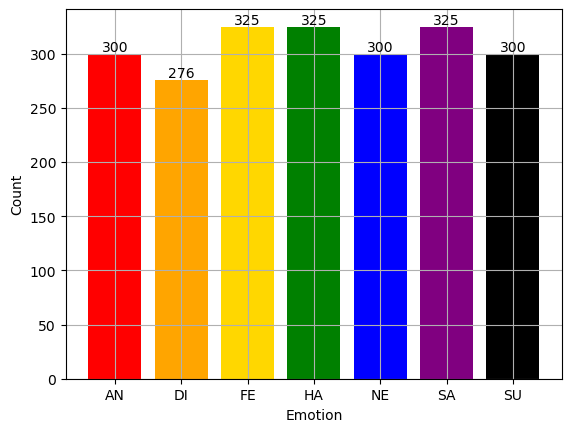

In [18]:
data = np.load("jaffe_da.npz")
x_train = data["x_train"]
x_test = data["x_test"]
y_train = data["y_train"]
y_test = data["y_test"]

VisualizeCounts(y_train)

In [ ]:
x_train_sel = x_train[np.isin(y_train, "AN")]
DrawImages(x_train_sel)